<a href="https://colab.research.google.com/github/KaziShahHamza/Colab-Codes/blob/main/titanic3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# SMARTER FEATURE ENGINEERING + PREPROCESSING + MODELS
# Paste into a notebook. Assumes titanic.csv available or df already loaded.

import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# optional: xgboost (try import, but safe if not installed)
try:
    from xgboost import XGBClassifier
    xgb_available = True
except Exception as e:
    print("XGBoost not available:", e)
    xgb_available = False

In [ ]:
# ======================================
# 2. Load Dataset
# ======================================
# Option A: Load from Google Drive
from google.colab import drive
drive.mount('/content/drive')

# file_path = "/content/drive/MyDrive/datasets/iris.data"
# columns = ["sepal_length", "sepal_width", "petal_length", "petal_width", "species"]

df = pd.read_csv("/content/drive/MyDrive/datasets/Titanic-Dataset.csv")

# Option B: Load directly from GitHub (example: Iris)
# df = pd.read_csv("https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv")

print("Shape:", df.shape)
print(df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape: (891, 12)
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/

In [ ]:
# -----------------------
# 2) BASIC MISSING HANDLING (safe defaults)
# -----------------------
df["Age"].fillna(df["Age"].median(), inplace=True)
df["Fare"].fillna(df["Fare"].median(), inplace=True)
df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)

/tmp/ipython-input-1640046263.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Age"].fillna(df["Age"].median(), inplace=True)
/tmp/ipython-input-1640046263.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [ ]:
# -----------------------
# 3) FEATURE ENGINEERING (smarter)
# -----------------------
# Family features
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
df["IsAlone"] = (df["FamilySize"] == 1).astype(int)

# Fare per person
df["FarePerPerson"] = df["Fare"] / df["FamilySize"]

# Title (from Name) - common + rare grouping
df["Title"] = df["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)
df["Title"] = df["Title"].replace(
    ['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'], 'Rare')
df["Title"] = df["Title"].replace({'Mlle':'Miss','Ms':'Miss','Mme':'Mrs'})
df["Title"] = df["Title"].fillna("None")

# Deck (first letter of Cabin). fill unknown as 'U'
df["Deck"] = df["Cabin"].apply(lambda x: x[0] if pd.notnull(x) else "U")

# Ticket prefix (rough grouping)
def ticket_prefix(ticket):
    if not isinstance(ticket, str):
        return "NUM"
    # get first token, if that token is digits -> NUM else token
    token = ticket.split()[0]
    token = token.replace('.', '').replace('/', '')
    if token.isdigit():
        return "NUM"
    return token.upper()

df["TicketPrefix"] = df["Ticket"].apply(ticket_prefix)

# Age groups (binned)
df["AgeGroup"] = pd.cut(df["Age"], bins=[-1,12,18,30,50,120], labels=["Child","Teen","YoungAdult","Adult","Senior"])
df["AgeGroup"] = df["AgeGroup"].astype(str)  # convert to string so get_dummies works well

# Fare bin (quantiles)
df["FareBin"] = pd.qcut(df["Fare"], 4, labels=False)

# LastName + FamilyID to capture groups (family groups often share fate)
df["LastName"] = df["Name"].str.split(",").str[0].str.strip()
df["FamilyID"] = df["LastName"] + "_" + df["FamilySize"].astype(str)
# compress small families into 'Small'
fam_counts = df["FamilyID"].value_counts()
df["FamilyID"] = df["FamilyID"].apply(lambda x: x if fam_counts.get(x,0) > 1 else "Small")


In [ ]:
# -----------------------
# 4) ENCODE CATEGORICALS
# -----------------------
df["Sex"] = df["Sex"].map({"male":0, "female":1})

# choose categorical columns to one-hot encode
cols_to_onehot = ["Embarked", "Title", "Deck", "TicketPrefix", "AgeGroup", "FamilyID"]
df = pd.get_dummies(df, columns=cols_to_onehot, drop_first=True)


In [ ]:
# -----------------------
# 5) DROP UNUSED COLUMNS (after features are extracted)
# -----------------------
drop_cols = ["PassengerId", "Name", "Ticket", "Cabin", "LastName"]
df.drop(columns=drop_cols, inplace=True, errors="ignore")


In [ ]:
# -----------------------
# 6) PREPARE X, y and SPLIT
# -----------------------
X = df.drop("Survived", axis=1)
y = df["Survived"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

In [ ]:
# -----------------------
# 7) MODEL SETUP (pipelines for scaled models)
# -----------------------
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()  # after get_dummies all are numeric, but scaler is fine
# We'll scale inside pipelines for models that benefit from scaling.

lr_pipe = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=3000))])
svc_pipe = Pipeline([("scaler", StandardScaler()), ("clf", SVC(probability=True))])
knn_pipe = Pipeline([("scaler", StandardScaler()), ("clf", KNeighborsClassifier())])

rf = RandomForestClassifier(n_estimators=300, max_depth=6, random_state=42, n_jobs=-1)
gb = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42)

if xgb_available:
    xgb = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=4, use_label_encoder=False, eval_metric="logloss", random_state=42)

models = [
    ("LogisticRegression", lr_pipe),
    ("SVC", svc_pipe),
    ("KNN", knn_pipe),
    ("RandomForest", rf),
    ("GradientBoosting", gb)
]
if xgb_available:
    models.append(("XGBoost", xgb))


In [ ]:
# -----------------------
# 8) QUICK CROSS-VALIDATION (stratified)
# -----------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Cross-validation scores (mean ± std):")
for name, m in models:
    scores = cross_val_score(m, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
    print(f"{name:15s} {scores.mean():.4f} ± {scores.std():.4f}")


Cross-validation scores (mean ± std):
LogisticRegression 0.8020 ± 0.0286
SVC             0.7978 ± 0.0305
KNN             0.8062 ± 0.0189
RandomForest    0.8160 ± 0.0172
GradientBoosting 0.8245 ± 0.0250
XGBoost         0.8301 ± 0.0169


In [ ]:
# -----------------------
# 9) FIT ON TRAIN & EVALUATE ON TEST
# -----------------------
fitted_models = {}
print("\nTest set accuracies:")
for name, m in models:
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    fitted_models[name] = m
    print(f"{name:15s} {acc:.4f}")

# Show classification report for best model (pick best by test acc)
best_name = max(fitted_models.items(), key=lambda kv: accuracy_score(y_test, kv[1].predict(X_test)))[0]
print("\nBest model on test set:", best_name)
print(classification_report(y_test, fitted_models[best_name].predict(X_test)))
print("Confusion matrix:")
print(confusion_matrix(y_test, fitted_models[best_name].predict(X_test)))



Test set accuracies:
LogisticRegression 0.7207
SVC             0.7374
KNN             0.7318
RandomForest    0.8101
GradientBoosting 0.8324


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:17:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost         0.8045

Best model on test set: GradientBoosting
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       110
           1       0.79      0.77      0.78        69

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

Confusion matrix:
[[96 14]
 [16 53]]


In [ ]:
# -----------------------
# 10) STACKING (meta-model) — often gives a further uplift
# -----------------------
stack_estimators = [
    ("lr", lr_pipe),
    ("rf", rf),
    ("gb", gb)
]
if xgb_available:
    stack_estimators.append(("xgb", xgb))

stack = StackingClassifier(
    estimators=stack_estimators,
    final_estimator=LogisticRegression(max_iter=2000),
    cv=cv,
    n_jobs=-1,
    passthrough=False
)
stack.fit(X_train, y_train)
y_pred_stack = stack.predict(X_test)
print("\nStacking test accuracy:", accuracy_score(y_test, y_pred_stack))
print(classification_report(y_test, y_pred_stack))



Stacking test accuracy: 0.8044692737430168
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       110
           1       0.75      0.74      0.74        69

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



In [ ]:
# -----------------------
# 11) Simple randomized hyperparameter tuning example for RandomForest
# -----------------------
from scipy.stats import randint
param_dist = {
    "n_estimators": [100,200,300,500],
    "max_depth": [3,5,6,8,10, None],
    "min_samples_split": [2,4,6,8]
}
rand_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist,
                                 n_iter=20, cv=cv, scoring="accuracy", n_jobs=-1, random_state=42)
rand_search.fit(X_train, y_train)
print("\nRandomForest randomized search best score:", rand_search.best_score_)
print("Best params:", rand_search.best_params_)

# Fit best RF and show test accuracy
best_rf = rand_search.best_estimator_
print("Best RF test acc:", accuracy_score(y_test, best_rf.predict(X_test)))


RandomForest randomized search best score: 0.83430513148823
Best params: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': None}
Best RF test acc: 0.8044692737430168


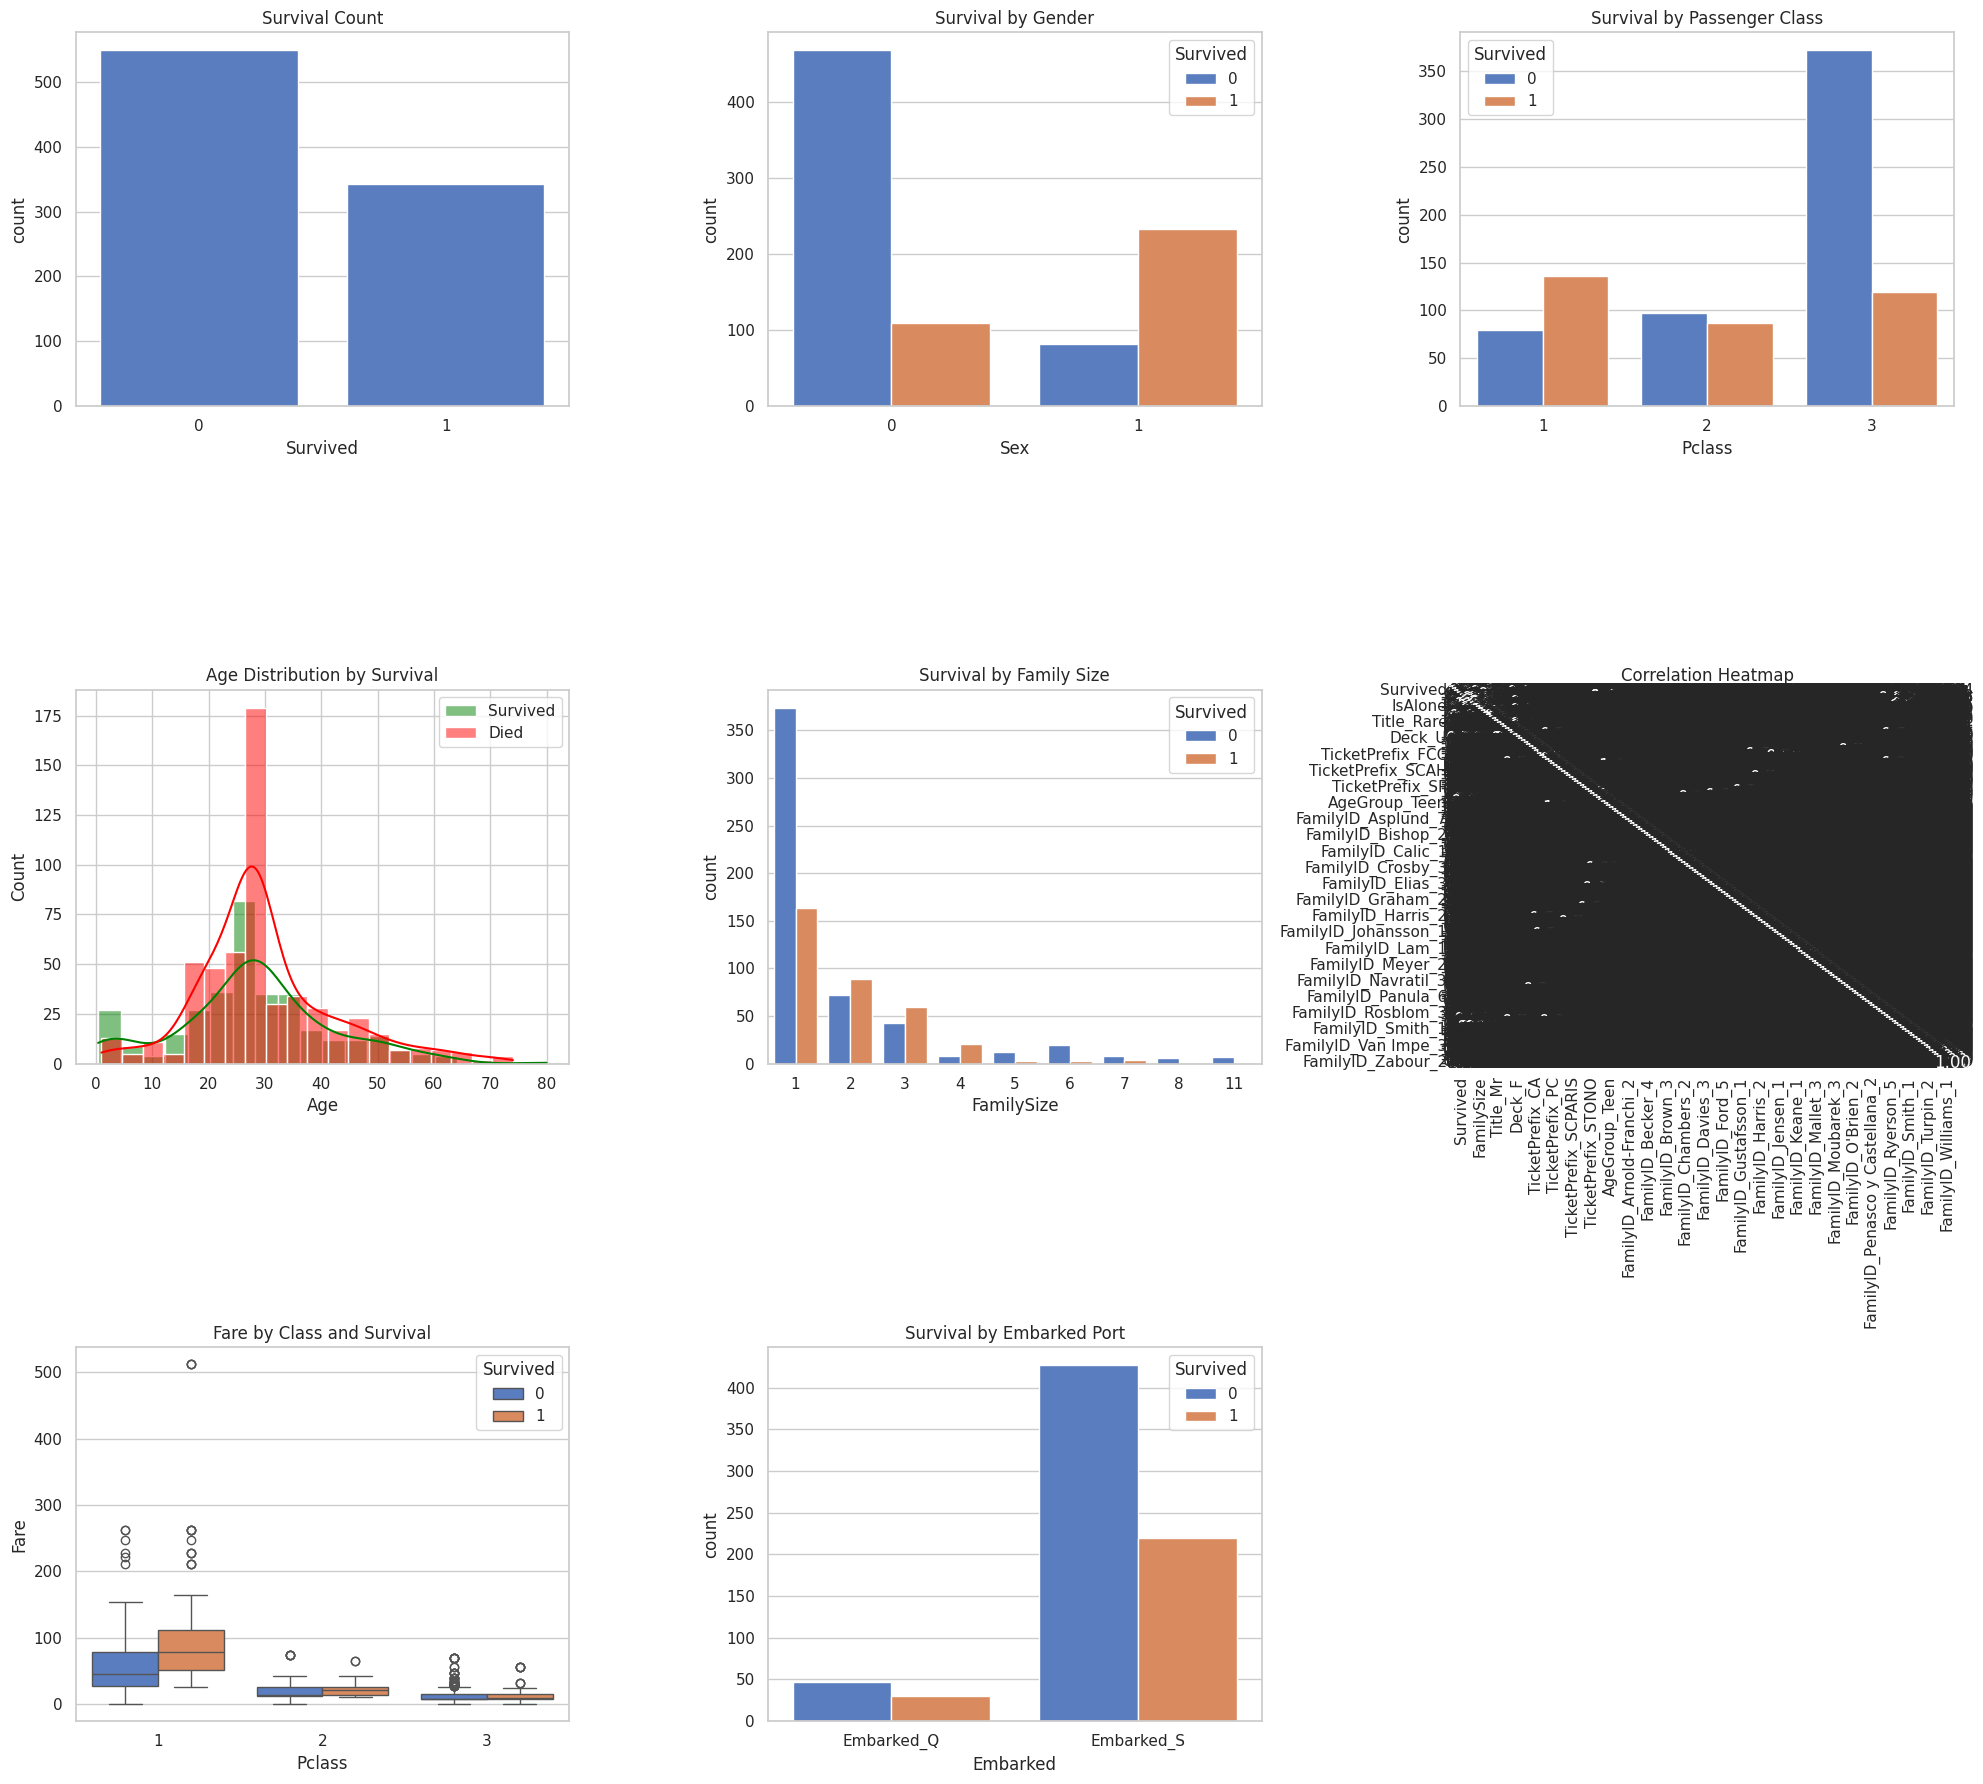

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid", palette="muted")
plt.figure(figsize=(20,18))

# 1. Survival Count
plt.subplot(3,3,1)
sns.countplot(x="Survived", data=df)
plt.title("Survival Count")

# 2. Survival by Gender
plt.subplot(3,3,2)
sns.countplot(x="Sex", hue="Survived", data=df)
plt.title("Survival by Gender")

# 3. Survival by Passenger Class
plt.subplot(3,3,3)
sns.countplot(x="Pclass", hue="Survived", data=df)
plt.title("Survival by Passenger Class")

# 4. Age Distribution by Survival
plt.subplot(3,3,4)
sns.histplot(df[df["Survived"]==1]["Age"], bins=20, kde=True, color="green", label="Survived")
sns.histplot(df[df["Survived"]==0]["Age"], bins=20, kde=True, color="red", label="Died")
plt.title("Age Distribution by Survival")
plt.legend()

# 5. Family Size Effect
plt.subplot(3,3,5)
sns.countplot(x="FamilySize", hue="Survived", data=df)
plt.title("Survival by Family Size")

# 6. Correlation Heatmap
plt.subplot(3,3,6)
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", cbar=False)
plt.title("Correlation Heatmap")

# 7. Boxplot of Fare by Class and Survival
plt.subplot(3,3,7)
sns.boxplot(x="Pclass", y="Fare", hue="Survived", data=df)
plt.title("Fare by Class and Survival")

# 8. Embarked vs Survival (all ports separately)
plt.subplot(3,3,8)
embarked_cols = [col for col in df.columns if col.startswith("Embarked_")]
df_melt = df.melt(id_vars="Survived", value_vars=embarked_cols, var_name="Embarked", value_name="Present")
sns.countplot(x="Embarked", hue="Survived", data=df_melt[df_melt["Present"]==1])
plt.title("Survival by Embarked Port")

plt.tight_layout()
plt.show()
